In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# building the dataset

block_size = 3 # how many characters we are taking to predict the next one.

def build_dataset(words):

    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for char in w + '.':
            X.append(context)
            ix = stoi[char]
            Y.append(ix)
            context = context[1:] + [ix]
    
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [72]:
n_embd, n_hidden = 10, 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),              generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden),  generator = g) * (5/3)/(n_embd * block_size)**0.5 # std = gain/(sqrt(fan_in))  #0.2
#b1 = torch.randn(n_hidden,                         generator = g) * 0
W2 = torch.randn((n_hidden, vocab_size),           generator = g) * 0.01
b2 = torch.randn((vocab_size),                     generator = g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [73]:
hpreact.shape

torch.Size([32, 200])

In [74]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 # hidden layer pre activation
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani)/ bnstdi + bnbias # batch normalization layer

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10000==0:
        print(f"{i}/{max_steps}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

0/200000: 3.3239
10000/200000: 2.0322
20000/200000: 2.5675
30000/200000: 2.0125
40000/200000: 2.2446
50000/200000: 1.8897
60000/200000: 2.0785
70000/200000: 2.3681
80000/200000: 2.2918
90000/200000: 2.0238
100000/200000: 2.3673
110000/200000: 2.3132
120000/200000: 1.6414
130000/200000: 1.9311
140000/200000: 2.2231
150000/200000: 2.0027
160000/200000: 2.0997
170000/200000: 2.4949
180000/200000: 2.0199
190000/200000: 2.1707


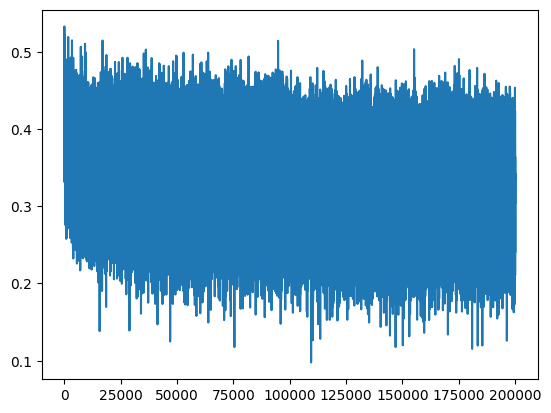

In [75]:
plt.plot(lossi)

In [76]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(Xtr.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    # measuring mean and standard deviation over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)


In [77]:
@torch.no_grad # this decorator disables gradient tracking

def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    # hpreact = bngain * (hpreact - hpreact.mean(dim=0, keepdim=True))/ hpreact.std(dim=0, keepdim=True) + bnbias # batch normalization layer
    hpreact = bngain * (hpreact - bnmean_running)/ bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056840419769287


In [ ]:
# intially :
train 2.1271157264709473
val 2.168189764022827

# after changes to (W2, b2) --> fix softmax and (W1, b1) --> tanh layer, we got
train 2.0360171794891357
val 2.103365659713745

In [80]:
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running)/ bnstd_running + bnbias
        h = torch.tanh(hpreact) #+ b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        out.append(ix)
        if ix == 0:
            break
        context = context[1:] + [ix]
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
ndheyah.
reisha.
endraeg.
adelynnelin.
shy.
jen.
eden.
sana.
arleigh.
malaia.
nosadhvighairiel.
kindreelynn.
novana.
uberted.
ryyah.
faeha.
kayshayklynn.
